In [8]:
from mnist import MNIST
import numpy as np
import random
from matplotlib import pyplot as plt

mndata = MNIST('/home/nbuser/python-mnist/data')
all_raw_images, all_labels = mndata.load_training()

all_raw_images = np.asarray(all_raw_images)
all_labels = np.asarray(all_labels)

In [9]:
def whiten(images):
    out = (np.asarray(images)) / np.std(images)
    out = out - np.mean(out)
    return out
    
images = whiten(all_raw_images)[:50000]
labels = all_labels[:50000]

val_images = whiten(all_raw_images)[50000:]
val_labels = all_labels[50000:]

all_raw_test_images, test_labels = mndata.load_testing()
test_images = whiten(all_raw_test_images)
test_labels = np.asarray(test_labels)

Raw
33.3184214498
6172.85048229
Whitened
0.000976324968854
1.00251425221


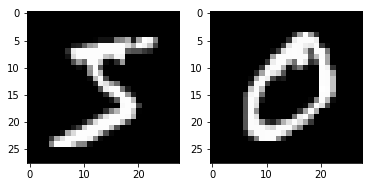

50000


In [12]:
print("Raw")
print(np.mean(all_raw_images))
print(np.var(all_raw_images))

print("Whitened")
print(np.mean(images))
print(np.var(images))


def show_images(images):
    n = len(images)
    fig, axarr = plt.subplots(1, n)

    for i in range(n):
        im = images[i]
        im = np.asarray(im)

        im = im.reshape([28,28])
        axarr[i].imshow(im, cmap='gray')

    plt.show()
    
show_images(images[:2])
print(len(images))

Whitened Test
-1.77187063208e-16
1.0


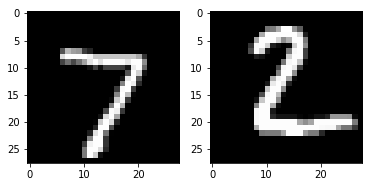

10000


In [14]:
print("Whitened Test")
print(np.mean(test_images))
print(np.var(test_images))

show_images(test_images[:2])
print(len(test_images))

In [15]:
import tensorflow as tf
print(tf.__version__)

1.1.0


In [16]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/gpu:0']


In [17]:
# b = tf.random_normal([20000])
# ary = b.eval()
# plt.hist(ary, 50)
# plt.show()
# print(ary.mean())
# print(ary.std())

In [18]:
# Test that we're using the GPU
shape = (1500, 1500)
from datetime import datetime
with tf.device('/gpu:0'):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    for i in range(200):
        result = session.run(sum_operation)
#         print(result)

In [71]:
# Set the seed for determinism
tf.reset_default_graph()
tf.set_random_seed(1)

# Build our models
input_size = 28*28
output_size = 10
batch_size = 50 # To use GPU correctly
hidden_size = 128*2


with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, shape=(None, input_size))
    y_train = tf.placeholder(tf.int32, shape=(batch_size))

    W1 = tf.Variable(tf.truncated_normal([input_size, hidden_size], stddev=0.1), name='W1')
    b1 = tf.Variable(tf.constant(0.1, shape=[hidden_size]))
    h1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    W2 = tf.Variable(0.01 * tf.truncated_normal([hidden_size, output_size], stddev=0.1), name='W2')
    b2 = tf.Variable(tf.constant(0.1, shape=[output_size]))
    logits = tf.matmul(h1, W2) + b2

    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    # Optimizers
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    # global_step = tf.Variable(0, trainable=False, name="global_step")
    # train_op = optimizer.minimize(loss, global_step=global_step)
    train_op = optimizer.minimize(loss)

    
sess = tf.InteractiveSession()

In [72]:
def check_accuracy(test_ims, test_ys):
    logits_out = sess.run(logits, feed_dict={
        x: test_ims,
    })

    y_pred = np.argmax(logits_out, 1)
    correct = (y_pred - test_ys) == 0
    acc = np.sum(correct) / len(test_ys)

    message = "%s correct out of %s => accuracy: %s" % ( np.sum(correct), len(test_ys), acc)
    return acc, message
    

In [73]:
report = {
    'loss': [],
    'val_acc': [],
}

def sample(images, labels, n=50):
    sample_indices = random.sample(range(len(images)), 50)
    return images[sample_indices], labels[sample_indices]

n_epochs = 20

# Clear out the session
sess.run(tf.global_variables_initializer())
for i in range(n_epochs*1000+1):
    # Train with a minibatch

    train_ims, train_labels = sample(images, labels)
        
    _, l = sess.run([train_op, loss], feed_dict={
        x: train_ims,
        y_train: train_labels,
    })

    if i % 100 == 0:
        report['loss'].append(l)
        acc, acc_msg = check_accuracy(val_images, val_labels)
        report['val_acc'].append(acc)
        
        
    if i % 1000 == 0:
        print("\nIteration: %s loss: %s" % (i, l))
        print(acc_msg)
        
        
        


Iteration: 0 loss: 2.30496
1598 correct out of 10000 => accuracy: 0.1598

Iteration: 1000 loss: 0.292962
9133 correct out of 10000 => accuracy: 0.9133

Iteration: 2000 loss: 0.327214
9307 correct out of 10000 => accuracy: 0.9307

Iteration: 3000 loss: 0.145189
9411 correct out of 10000 => accuracy: 0.9411

Iteration: 4000 loss: 0.186563
9496 correct out of 10000 => accuracy: 0.9496

Iteration: 5000 loss: 0.102935
9554 correct out of 10000 => accuracy: 0.9554

Iteration: 6000 loss: 0.167529
9611 correct out of 10000 => accuracy: 0.9611

Iteration: 7000 loss: 0.0816247
9633 correct out of 10000 => accuracy: 0.9633

Iteration: 8000 loss: 0.147931
9670 correct out of 10000 => accuracy: 0.967

Iteration: 9000 loss: 0.125996
9694 correct out of 10000 => accuracy: 0.9694

Iteration: 10000 loss: 0.062319
9704 correct out of 10000 => accuracy: 0.9704

Iteration: 11000 loss: 0.0429517
9706 correct out of 10000 => accuracy: 0.9706

Iteration: 12000 loss: 0.0602171
9733 correct out of 10000 => ac

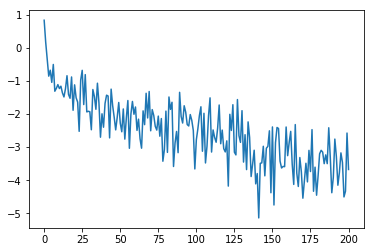

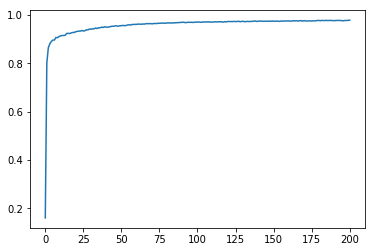

(0.97629999999999995, '9763 correct out of 10000 => accuracy: 0.9763')

In [74]:
plt.plot(np.log(report['loss']))
plt.show()

plt.plot(report['val_acc'])
plt.show()


check_accuracy( test_images, test_labels)